# Step1: Initializing the main and target CNN models

In [41]:
# imports
import cv2
import math
import numpy as np
import random
# reinforcement learning related
import re
import atari_py as ap
from collections import deque
from gym import make, ObservationWrapper, Wrapper
from gym.spaces import Box
# PyTorch imports
import torch
import torch.nn as nn
from torch import save
from torch.optim import Adam
import ale_py
import gym
import matplotlib.pyplot as plt

### define the CNN model and functions such as forward passing and taking actions
It takes input size, total number of actions as input, output probability of taking each action;
the network has 3 convolutional layers with 32, 64, 64 filters with sizes 8* 8, 4* 4, 3*3

In [42]:
class CNN(nn.Module):
    def __init__(self, input_size, num_action):
        super(CNN,self).__init__()
        self._input_size = input_size
        self._num_action = num_action
        self.convLayer = nn.Sequential(
            nn.Conv2d(self._input_size[0],32,8,4),
            nn.ReLU(),
            nn.Conv2d(32,64,4,2),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1),
            nn.ReLU()
        )
        self.linearLayer = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512,self._num_action)
        )
    def forward(self, x):
        # go through convolutional layers
        output = self.convLayer(x)
        # faltten the features
        output = output.view(x.size()[0],-1) # keep the batch dimension, and flatten the rest
        output = self.linearLayer(output)
        return output
    
    @property
    def feature_size(self):
        x = torch.zeros(1,*self._input_size)
        x = self.convLayer(x)
        return x.view(1,-1).size(1) # keep the first dimension as 1, and see what size the second
                                     #  dimension after flatten
    
    def take_action(self, state, device):
        if True: # always greedy
            state = torch.from_numpy(np.double(state)).unsqueeze(0).to(device) # convert 
                #  state to float, increase a dimension, then sent to device where the model is
            state = state.float()
            # calculate Q values for each available action
            Q = self.forward(state)
            
            # choose an action accordingly
            #  torch.max(a,1) returns max values and their indices, we want the index
            #  representing the action with max Q value
            action = Q.max(1)[1].item()
        
        else: # select actions randomly
            action = random.randrange(self._num_action)
        return action
        
        

### define the function that instantiates the main neural network and the target neural network

In [43]:
# Add the option to load trained weights!!!!!!!!!!!!
def agent_initialize(env,device,path):
    agent = CNN(env.observation_space.shape,env.action_space.n).to(device)
    agent.load_state_dict(torch.load(path))
    print("Weights loaded")
    
    return agent

# Step2: define the experience replay buffer
store transitions (frames) of the game to train the CNN model with random sampling

In [44]:
class ReplayBuffer:
    def __init__(self, cap_max):
        # cap_max is the defined buffer size, the number of state trasitions that stored in the buffer
        self._buffer = deque(maxlen=cap_max) # use deque to speed up the append and pop operations
    
    # append (state, action, reward, next state, finish) tuple
    def push(self, state, action, reward, next_state, finish):
        self._buffer.append((state,action,reward,next_state,finish))
    
    
    def sample(self, batch_size):
        idxs = np.random.choice(len(self._buffer),batch_size,False) # chose random samples
        # e.g. idxs = (1,5,67,51,34,97,105,...)
        
        batch = zip(*[self._buffer[i] for i in idxs]) # put corresponding frames to a zipped list
        # e.g. batch = ((state_1,action_1.reward_1,next_state_1,finish_1),
        #                (state_5,action_5,reward_5,next_state_5,finish_5, ...)
        
        state, action, reward, next_state, finish = batch # create array for each category
        # e.g. state = (state_1,state_5,state_67,...)
        #      action = (action_1, action_5, action_67, ...)
        #      ...
        return (np.array(state),np.array(action),np.array(reward,dtype=float),
                 np.array(next_state),np.array(finish,dtype=np.uint8))
    
    def __len__(self):
        return len(self._buffer)

# Step 3: setting up environment

### define some initialization-related functions

In [45]:
# replace some string with _
def gym_to_atari_format(gym_env):
    return re.sub(r"(?<!^)(?=[A-Z])", "_", gym_env).lower()

# 
def check_atari_env(env):
    for f in ["Deterministic", "ramDeterministic", "ram", "NoFrameskip", "ramNoFrameSkip"]:
        env = env.replace(f, "")
    env = re.sub(r"-v\d+", "", env)
    env = gym_to_atari_format(env) 
    return True if env in ap.list_games() else False

### augment gym environment in a series of steps, 
include 1) downsampling the video game image frames, 2) pushing iamge frames to the experience replay buffer 3) converting images into PyTorch tnesors, ...  

In [46]:
# reseting environment for both atari or non-atari environment
class CCtrl(Wrapper):
    def __init__(self,env,is_atari):
        super(CCtrl,self).__init__(env)
        self._is_atari = is_atari
        
    def reset(self):
        if self._is_atari:
            return self.env.reset()
        else:
            self.env.reset()
            return self.env.render(mode="rgb_array")

# observations (frames) will be converted to grey-scale and reshape to (84,84)
class FrmDwSmpl(ObservationWrapper):
    def __init__(self, env):
        super(FrmDwSmpl,self).__init__(env)
        self.observation_space = Box(low=0,high=255,shape=(84,84,1),dtype=np.uint8)
        self._width=84
        self._height = 84
        
    def observation(self,observation):
        frame = cv2.cvtColor(observation,cv2.COLOR_RGB2GRAY) # turn the image to gray
        frame = cv2.resize(frame,(self._width,self._height), interpolation=cv2.INTER_AREA)
        return frame[:,:,None]
    
    
# use frame-skipping technique
class MaxNSkpEnv(Wrapper):
    def __init__(self, env, atari, skip=4):
        super(MaxNSkpEnv,self).__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip
        self._atari = atari
    
    def step(self,action):
        total_reward = 0
        finish = None
        for _ in range(self._skip):
            # take a step
            obs, reward, finish, log = self.env.step(action)
            if not self._atari:
                obs = self.env.render(mode="rgb_array")
            # append the new stsate to the double ended queue buffer
            self._obs_buffer.append(obs)
            # accumulate the reward
            total_reward += reward
            if finish:
                break
        # buffer holds the last two frames, they are max-pooled, resulting in an observation
        #  that contains some temporal information
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, finish, log
    
    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs
    
    

class FrRstEnv(Wrapper):
    def __init__(self,env):
        Wrapper.__init__(self,env)
        if len(env.unwrapped.get_action_meanings()) < 3:
            raise ValueError("min requred action space of 3!")
    
    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(1)
        if finish:
            self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(2)
        if finish:
            self.env.reset(**kwargs)
        return obs
    
    def step(self, action):
        return self.env.step(action)
    

class FrmBfr(ObservationWrapper):
    def __init__(self,env,num_steps,dtype=float):
        super(FrmBfr,self).__init__(env)
        obs_space = env.observation_space
        self._dtype = dtype
        self.observation_space = Box(obs_space.low.repeat(num_steps,axis=0),
                        obs_space.high.repeat(num_steps,axis=0), dtype=self._dtype)
    
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low,dtype=self._dtype)
        return self.observation(self.env.reset())
    
    def observation(self,observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer
#
class Img2Trch(ObservationWrapper):
    def __init__(self,env):
        super(Img2Trch,self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(low=0,high=1,shape=(obs_shape[::-1]),dtype=float)
    
    def observation(self,observation):
        # move the last channel to the first place, experiment!!!!!!!
        return np.moveaxis(observation,2,0)

# normalizing pixel values
class NormFlts(ObservationWrapper):
    def observation(self,obs):
        return np.array(obs).astype(float) / 255




define a method that takes in the raw Pong video game environment as input and augments the environment, as follows:

In [47]:
def wrap_env(env_ip):
    env = gym.make(env_ip)
    is_atari = check_atari_env(env_ip) 
    env = CCtrl(env, is_atari) # preparing to reseting environment
    env = MaxNSkpEnv(env, is_atari) # initialize frame-skipping technique
    try:
        env_acts = env.unwrapped.get_action_meanings()
        if "FIRE" in env_acts:
            env = FrRstEnv(env)
    except AttributeError:
        pass
    env = FrmDwSmpl(env) # preprocessing pixels
    env = Img2Trch(env) # convert to tensor 
    env = FrmBfr(env,4) # initilize frame buffers
    env = NormFlts(env) # normalize pixel values
    return env
        

# Step 4: Defining the CNN optimization function

In [48]:
def convert(data,device):
    # data should be a numpy array
    return torch.from_numpy(data).to(device)

# Step5: managing and running episodes

In [49]:
# define the function to take action after end of an episode
#  if the overall reward that's scored in the current episode is the best we've achieved so far
#  we save the CNN model weights and print the reward value
def finish_episode(agent,log,ep_reward,ep):
    best_so_far = log.update_rewards(ep_reward)
    log.update_average_rewards()
        
    print(f"EP {ep}, curr_reward: {ep_reward}, running_avg_reward: {round(log.average, 3)}, num of losses: {log.num_loss}")

In [57]:
# define the DQN loop
def run_episodes(env,agent,device,log,ep):
    # initializing
    episode_reward = 0.0
    state = env.reset()
    
    
    while True: 
        action = agent.take_action(state,device) # choose an action to take
        env.render() # display the environment
        next_state, reward, finish, _ = env.step(action)  # take the action
        
        # prepare for next iteration
        state = next_state 
        episode_reward += reward
        log.update_idx()
        
        # break if reached end of the episode
        if finish:
            finish_episode(agent,log,episode_reward,ep)
            break

# Step 6: define the matadata class

In [51]:
class TrMetadata:
    def __init__(self):
        self._average = 0.0
        self._num_loss = 0
        self._rewards = []
        self._average_rewards = [] # keep track of average rewards
        self._average_range = 100
        self._idx = 0
    
    @property
    def best_reward(self):
        return self._best_reward
    
    @property
    def best_average(self):
        return self._best_average
    
    @property
    def average(self):
        average_range = self._average_range * -1
        average_reward = sum(self._rewards[average_range:]) / len(self._rewards[average_range:])
        return average_reward
    
    @property
    def idx(self):
        return self._idx
    
    @property
    def num_loss(self):
        return self._num_loss
    
    
    def _update_num_loss(self,episode_reward):
        if episode_reward < 15:
            self._num_loss += 1
            

    
    def update_rewards(self,episode_reward):
        self._rewards.append(episode_reward)
        self._update_num_loss(episode_reward)
    
    def update_average_rewards(self):
        self._average_rewards.append(self.average)
    
    def update_idx(self):
        self._idx += 1

# Game On

In [52]:
from tqdm.auto import tqdm

def game_on(env,agent,device):    
    log = TrMetadata()
    progress = tqdm(range(N_EPDS))
    
    for ep in np.arange(N_EPDS):
        run_episodes(env,agent,device,log,ep)
        progress.update(1)
    
    # return rewrads and average rewards
    return log._average_rewards, log._rewards

In [53]:
# hypterparameters 
ENV = "Pong-v4"


# Initialization - run every time

In [54]:
# start training
env = wrap_env(ENV)
device = "cuda"
path = "Weights/Pong-v4_run4_last.pth"
agent = agent_initialize(env,device,path)



Weights loaded


In [55]:
def plot_rewards(re,num_eps,reward_type,run,agent):
    # plot and save the figure
    plt.figure(figsize=(12,8))
    x = np.arange(1,num_eps+1)
    filepath = "Games_agent_"+str(agent)+"/Game_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_runs.jpg"
    plt.plot(x,re)
    plt.xlabel("Episodes")
    plt.ylabel(f"{reward_type} Reward")
    plt.title(f"{reward_type} rewards for {num_eps} episodes")
    plt.savefig(filepath)
    plt.show()
    
    # save the array
    arraypath = "Games_agent_"+str(agent)+"/Game_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_runs.npy"
    np.save(arraypath,re)
    

In [56]:
def pretty_plot(re,ave_re,run,agent):
    plt.figure(figsize=(12,8))
    x = np.arange(1,len(re)+1)
    plt.plot(x,re,color=(0.999,0.8,0.9))
    plt.plot(x,ave_re,color=(0.9,0,0))
    plt.legend(["Rewards", "Average Rewards"],loc="lower right")
    plt.title(f"Overview of rewards achieved in run {run} with agent {agent}")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    filepath = "PrettyFig/Games_agent_"+str(agent)+"_Game_"+str(run)+".jpg"
    plt.savefig(filepath)
    plt.show()

# Play 1000 games with run3 agent

### 1st Game:
#### Average: 19.26
#### Num of games below 15: 3
#### Num of games below 0: 1

In [17]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


EP 0, curr_reward: 20.0, running_avg_reward: 20.0, num of losses: 0
EP 1, curr_reward: 19.0, running_avg_reward: 19.5, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 20.0, num of losses: 0
EP 3, curr_reward: 16.0, running_avg_reward: 19.0, num of losses: 0
EP 4, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 19.333, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 19.571, num of losses: 0
EP 7, curr_reward: 15.0, running_avg_reward: 19.0, num of losses: 0
EP 8, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 9, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 10, curr_reward: 17.0, running_avg_reward: 18.818, num of losses: 0
EP 11, curr_reward: 21.0, running_avg_reward: 19.0, num of losses: 0
EP 12, curr_reward: 15.0, running_avg_reward: 18.692, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 18.857, num of losses: 0
EP 14, curr_reward: 21.0, running_

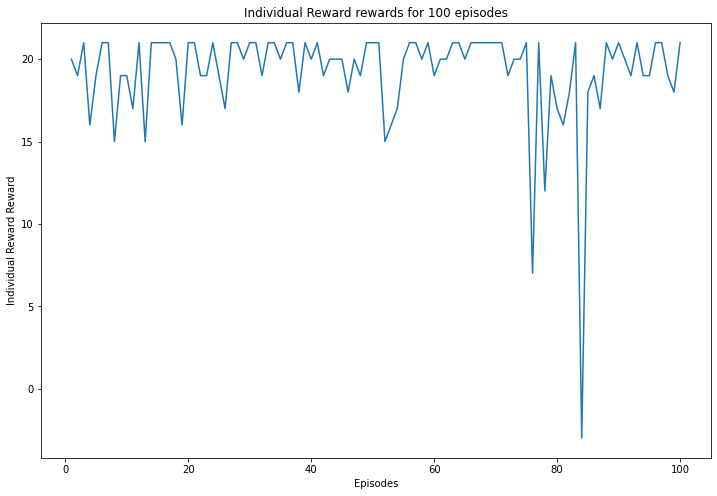

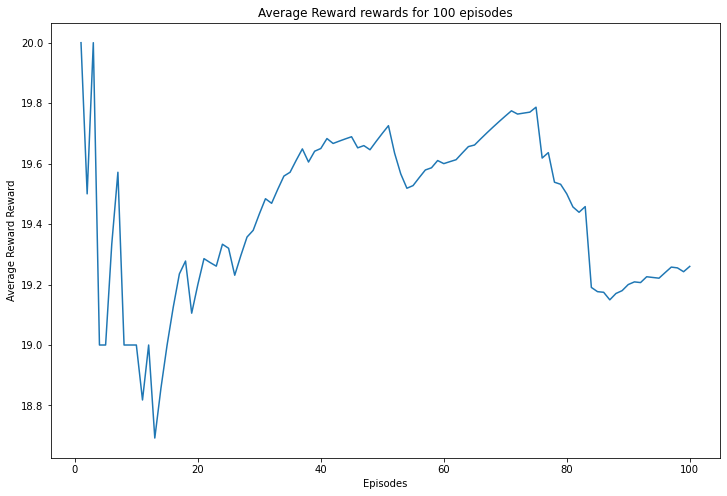

In [22]:
plot_rewards(re,100,"Individual Reward",1)
plot_rewards(ave_re,100,"Average Reward",1)

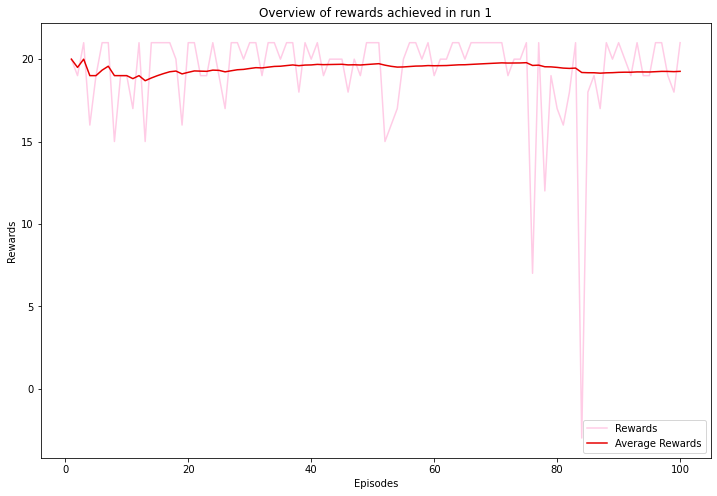

In [24]:
pretty_plot(re,ave_re,1)

### 2nd Game:
#### Average: 19.44
#### Num of games below 15 points: 5
#### Num of games below 0 points: 0

In [25]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 20.0, running_avg_reward: 20.0, num of losses: 0
EP 1, curr_reward: 20.0, running_avg_reward: 20.0, num of losses: 0
EP 2, curr_reward: 5.0, running_avg_reward: 15.0, num of losses: 1
EP 3, curr_reward: 19.0, running_avg_reward: 16.0, num of losses: 1
EP 4, curr_reward: 19.0, running_avg_reward: 16.6, num of losses: 1
EP 5, curr_reward: 21.0, running_avg_reward: 17.333, num of losses: 1
EP 6, curr_reward: 16.0, running_avg_reward: 17.143, num of losses: 1
EP 7, curr_reward: 21.0, running_avg_reward: 17.625, num of losses: 1
EP 8, curr_reward: 21.0, running_avg_reward: 18.0, num of losses: 1
EP 9, curr_reward: 20.0, running_avg_reward: 18.2, num of losses: 1
EP 10, curr_reward: 19.0, running_avg_reward: 18.273, num of losses: 1
EP 11, curr_reward: 21.0, running_avg_reward: 18.5, num of losses: 1
EP 12, curr_reward: 20.0, running_avg_reward: 18.615, num of losses: 1
EP 13, curr_reward: 21.0, running_avg_reward: 18.786, num of losses: 1
EP 14, curr_reward: 21.0, running

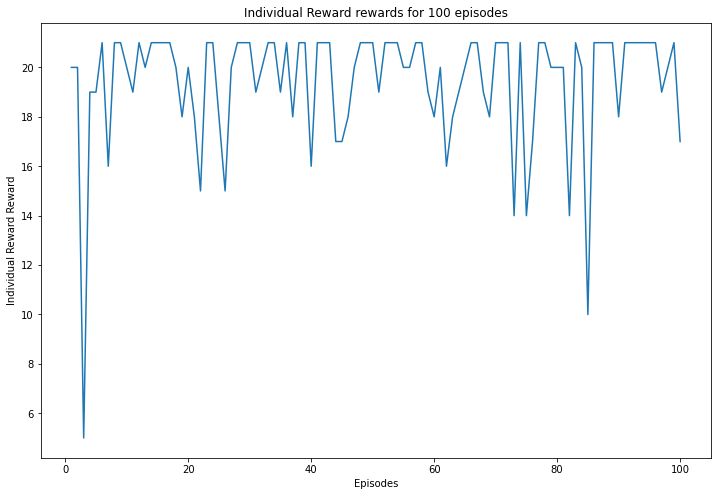

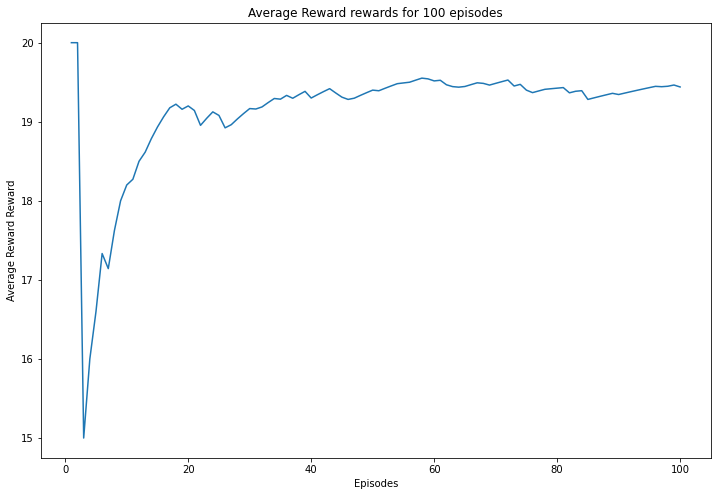

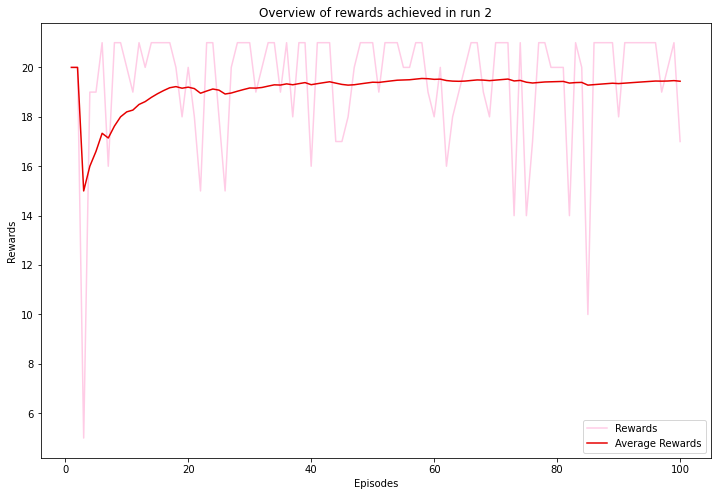

In [28]:
plot_rewards(re,100,"Individual Reward",2)
plot_rewards(ave_re,100,"Average Reward",2)
pretty_plot(re,ave_re,2)

### 3rd Game:
#### Average: 19.16
#### Num of games below 15 points: 6
#### Num of games below 0 points: 0

In [29]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 13.0, running_avg_reward: 17.0, num of losses: 1
EP 2, curr_reward: 20.0, running_avg_reward: 18.0, num of losses: 1
EP 3, curr_reward: 18.0, running_avg_reward: 18.0, num of losses: 1
EP 4, curr_reward: 21.0, running_avg_reward: 18.6, num of losses: 1
EP 5, curr_reward: 21.0, running_avg_reward: 19.0, num of losses: 1
EP 6, curr_reward: 21.0, running_avg_reward: 19.286, num of losses: 1
EP 7, curr_reward: 19.0, running_avg_reward: 19.25, num of losses: 1
EP 8, curr_reward: 21.0, running_avg_reward: 19.444, num of losses: 1
EP 9, curr_reward: 19.0, running_avg_reward: 19.4, num of losses: 1
EP 10, curr_reward: 21.0, running_avg_reward: 19.545, num of losses: 1
EP 11, curr_reward: 20.0, running_avg_reward: 19.583, num of losses: 1
EP 12, curr_reward: 21.0, running_avg_reward: 19.692, num of losses: 1
EP 13, curr_reward: 17.0, running_avg_reward: 19.5, num of losses: 1
EP 14, curr_reward: 20.0, running

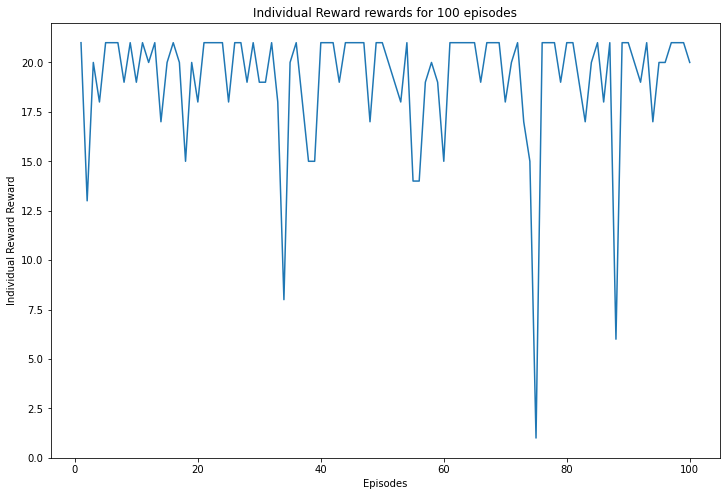

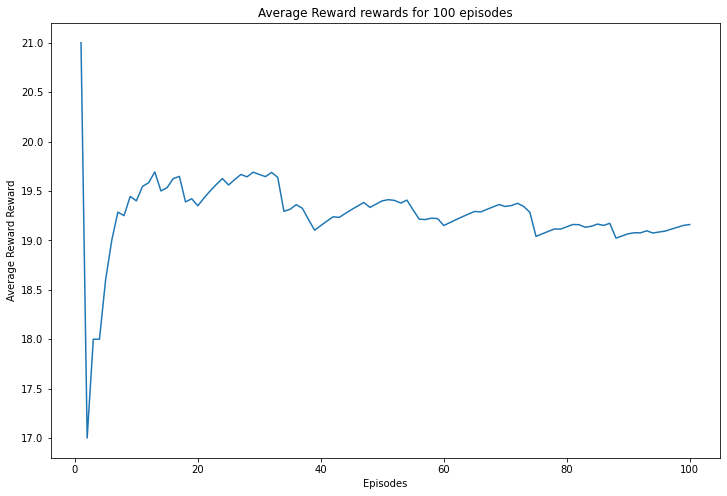

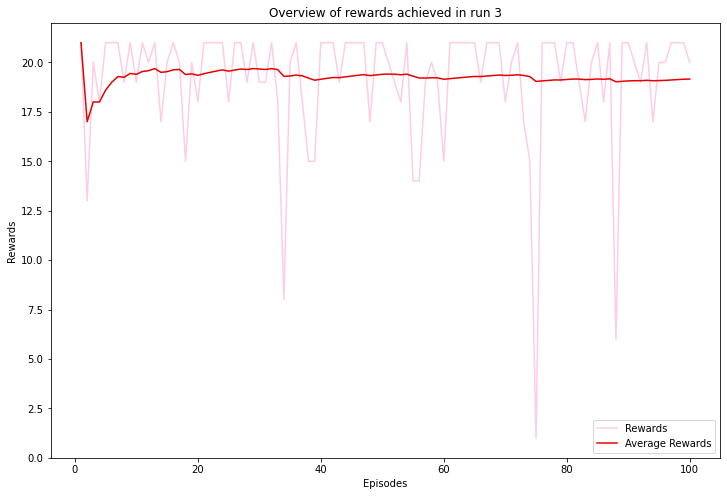

In [30]:
plot_rewards(re,100,"Individual Reward",3)
plot_rewards(ave_re,100,"Average Reward",3)
pretty_plot(re,ave_re,3)

### 4th game:
#### Average: 19.36
#### Num of games below 15 points: 6
#### Num of games below 0 points: 0

In [31]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 16.0, running_avg_reward: 16.0, num of losses: 0
EP 1, curr_reward: 18.0, running_avg_reward: 17.0, num of losses: 0
EP 2, curr_reward: 20.0, running_avg_reward: 18.0, num of losses: 0
EP 3, curr_reward: 19.0, running_avg_reward: 18.25, num of losses: 0
EP 4, curr_reward: 10.0, running_avg_reward: 16.6, num of losses: 1
EP 5, curr_reward: 21.0, running_avg_reward: 17.333, num of losses: 1
EP 6, curr_reward: 21.0, running_avg_reward: 17.857, num of losses: 1
EP 7, curr_reward: 17.0, running_avg_reward: 17.75, num of losses: 1
EP 8, curr_reward: 21.0, running_avg_reward: 18.111, num of losses: 1
EP 9, curr_reward: 21.0, running_avg_reward: 18.4, num of losses: 1
EP 10, curr_reward: 21.0, running_avg_reward: 18.636, num of losses: 1
EP 11, curr_reward: 19.0, running_avg_reward: 18.667, num of losses: 1
EP 12, curr_reward: 14.0, running_avg_reward: 18.308, num of losses: 2
EP 13, curr_reward: 20.0, running_avg_reward: 18.429, num of losses: 2
EP 14, curr_reward: 19.0, ru

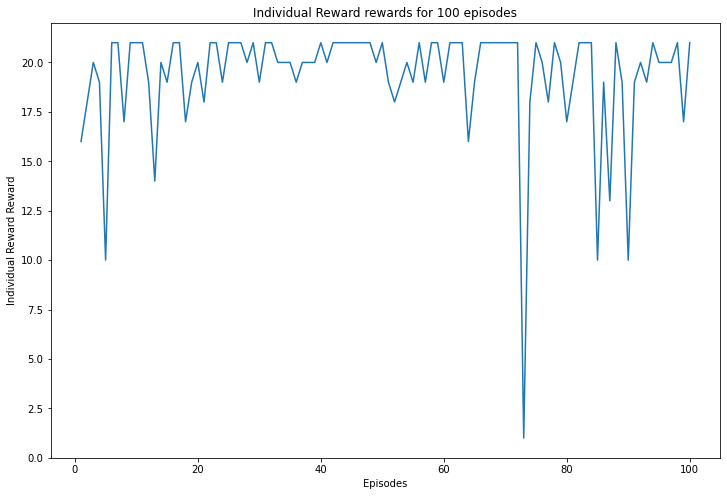

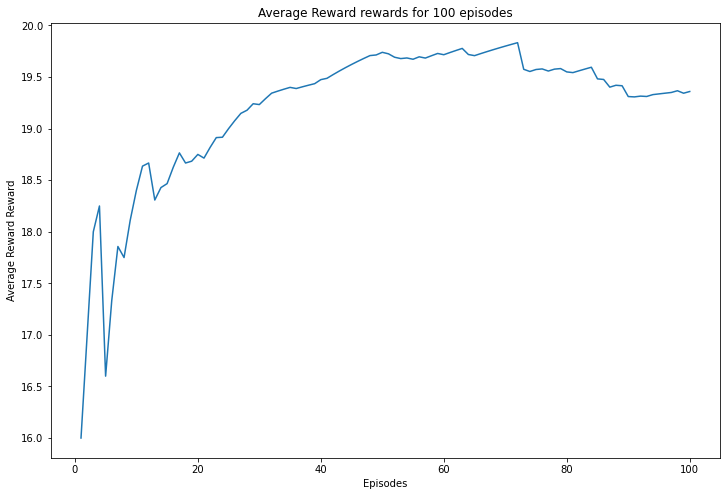

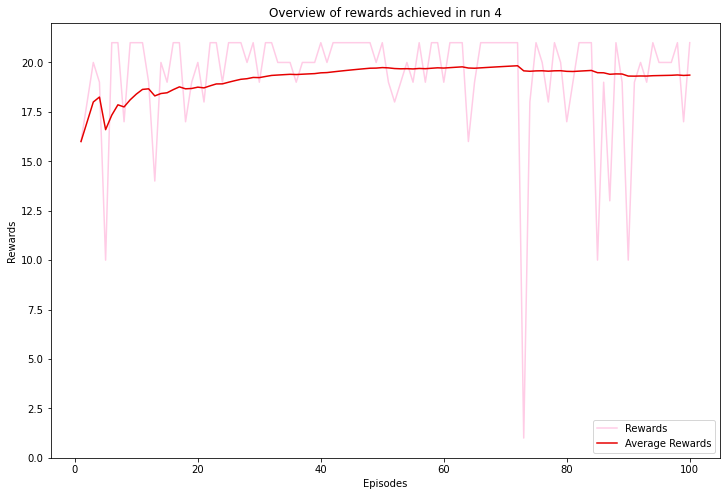

In [32]:
plot_rewards(re,100,"Individual Reward",4)
plot_rewards(ave_re,100,"Average Reward",4)
pretty_plot(re,ave_re,4)

### 5th game:
#### Average: 18.77
#### Num of games below 15 points: 9
#### Num of games below 0 points: 0

In [33]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 1, curr_reward: 15.0, running_avg_reward: 17.0, num of losses: 0
EP 2, curr_reward: 16.0, running_avg_reward: 16.667, num of losses: 0
EP 3, curr_reward: 19.0, running_avg_reward: 17.25, num of losses: 0
EP 4, curr_reward: 20.0, running_avg_reward: 17.8, num of losses: 0
EP 5, curr_reward: 17.0, running_avg_reward: 17.667, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 18.143, num of losses: 0
EP 7, curr_reward: 19.0, running_avg_reward: 18.25, num of losses: 0
EP 8, curr_reward: 21.0, running_avg_reward: 18.556, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 18.8, num of losses: 0
EP 10, curr_reward: 21.0, running_avg_reward: 19.0, num of losses: 0
EP 11, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 12, curr_reward: 16.0, running_avg_reward: 18.769, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 18.929, num of losses: 0
EP 14, curr_reward: 21.0, runn

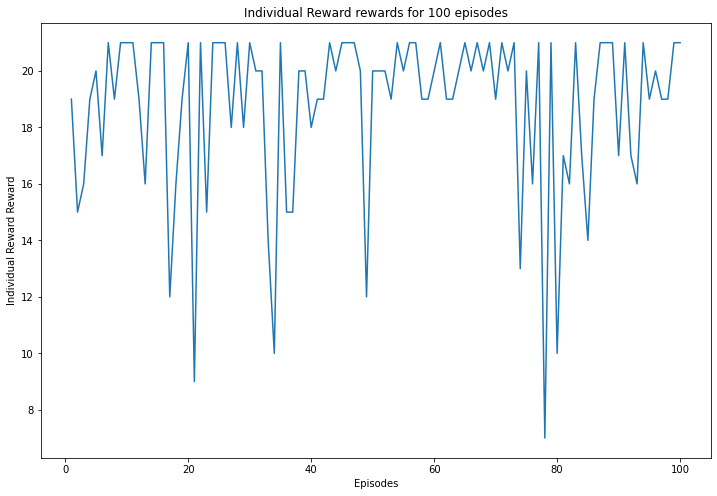

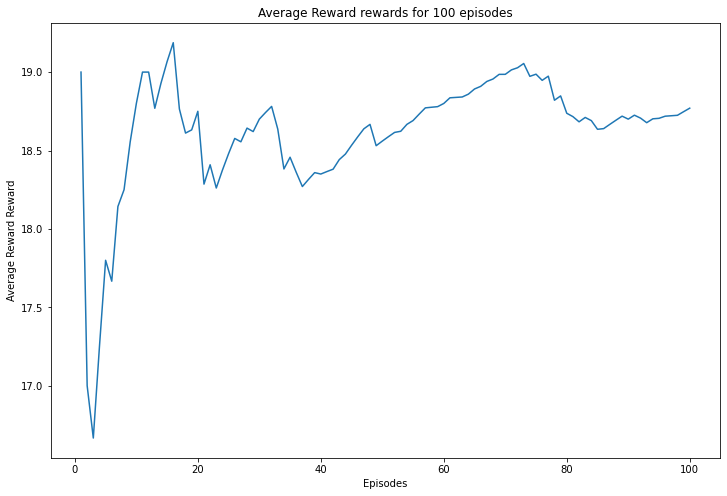

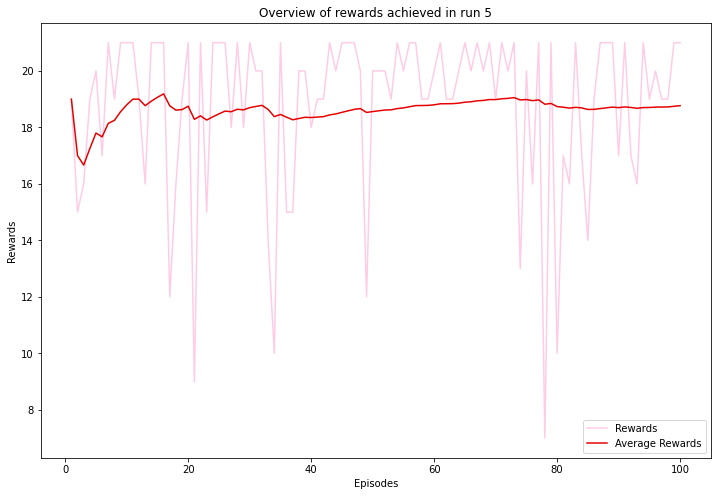

In [34]:
plot_rewards(re,100,"Individual Reward",5)
plot_rewards(ave_re,100,"Average Reward",5)
pretty_plot(re,ave_re,5)

### 6th game:
#### Average: 18.73
#### Num of games below 15 points: 8
#### Num of games below 0 points: 0

In [53]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 20.0, running_avg_reward: 20.5, num of losses: 0
EP 2, curr_reward: 17.0, running_avg_reward: 19.333, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 19.75, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 20.0, num of losses: 0
EP 5, curr_reward: 18.0, running_avg_reward: 19.667, num of losses: 0
EP 6, curr_reward: 18.0, running_avg_reward: 19.429, num of losses: 0
EP 7, curr_reward: 19.0, running_avg_reward: 19.375, num of losses: 0
EP 8, curr_reward: 18.0, running_avg_reward: 19.222, num of losses: 0
EP 9, curr_reward: 20.0, running_avg_reward: 19.3, num of losses: 0
EP 10, curr_reward: 20.0, running_avg_reward: 19.364, num of losses: 0
EP 11, curr_reward: 21.0, running_avg_reward: 19.5, num of losses: 0
EP 12, curr_reward: 21.0, running_avg_reward: 19.615, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 19.714, num of losses: 0
EP 14, curr_reward: 18.0, r

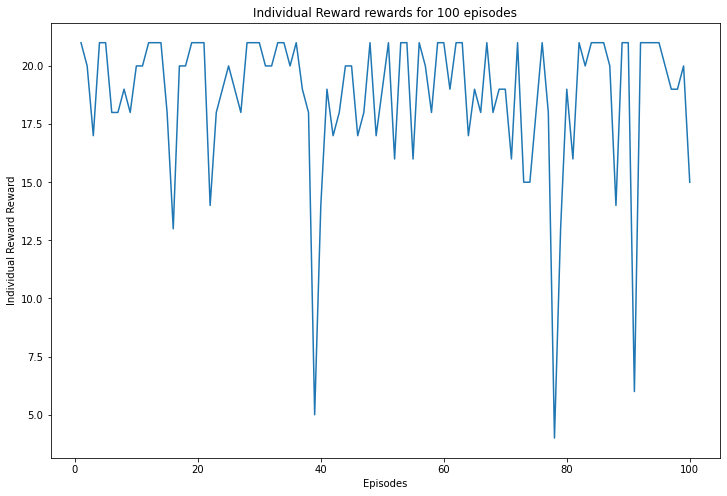

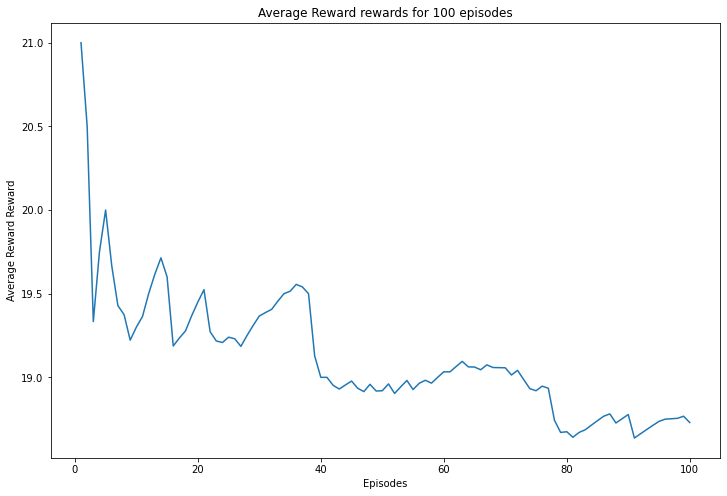

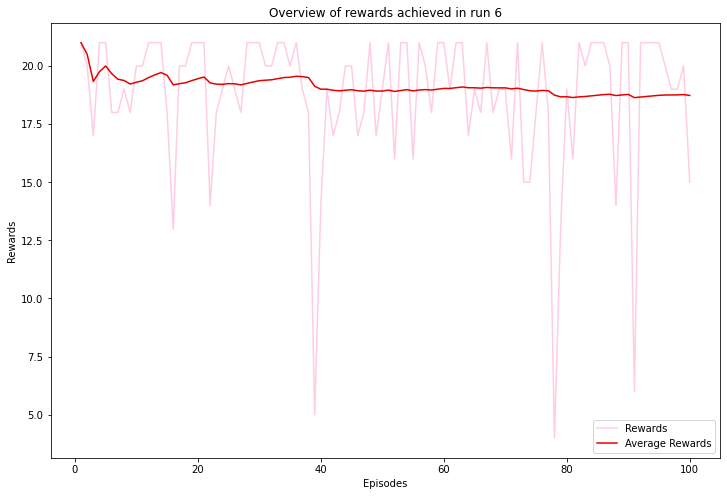

In [54]:
plot_rewards(re,100,"Individual Reward",6)
plot_rewards(ave_re,100,"Average Reward",6)
pretty_plot(re,ave_re,6)

### 7th game:
#### Average: 18.67
#### Num of games below 15 points: 8
#### Num of games below 0 points: 2

In [57]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 20.0, running_avg_reward: 20.5, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 20.667, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 20.75, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 20.8, num of losses: 0
EP 5, curr_reward: 20.0, running_avg_reward: 20.667, num of losses: 0
EP 6, curr_reward: 20.0, running_avg_reward: 20.571, num of losses: 0
EP 7, curr_reward: 19.0, running_avg_reward: 20.375, num of losses: 0
EP 8, curr_reward: 19.0, running_avg_reward: 20.222, num of losses: 0
EP 9, curr_reward: 20.0, running_avg_reward: 20.2, num of losses: 0
EP 10, curr_reward: 20.0, running_avg_reward: 20.182, num of losses: 0
EP 11, curr_reward: 18.0, running_avg_reward: 20.0, num of losses: 0
EP 12, curr_reward: 21.0, running_avg_reward: 20.077, num of losses: 0
EP 13, curr_reward: -2.0, running_avg_reward: 18.5, num of losses: 1
EP 14, curr_reward: 20.0, run

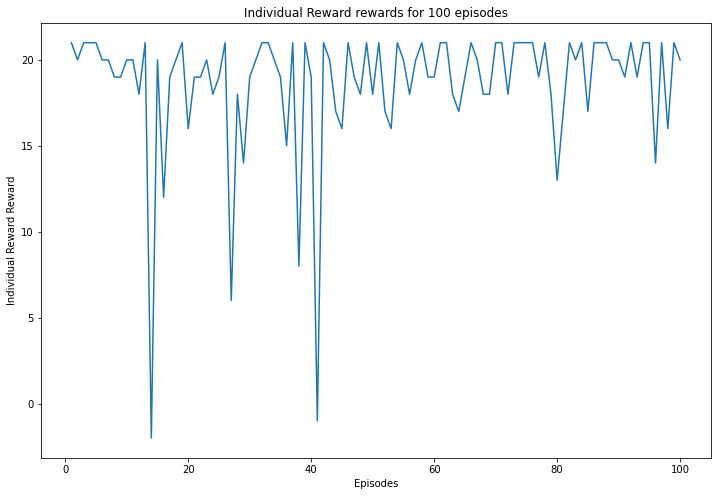

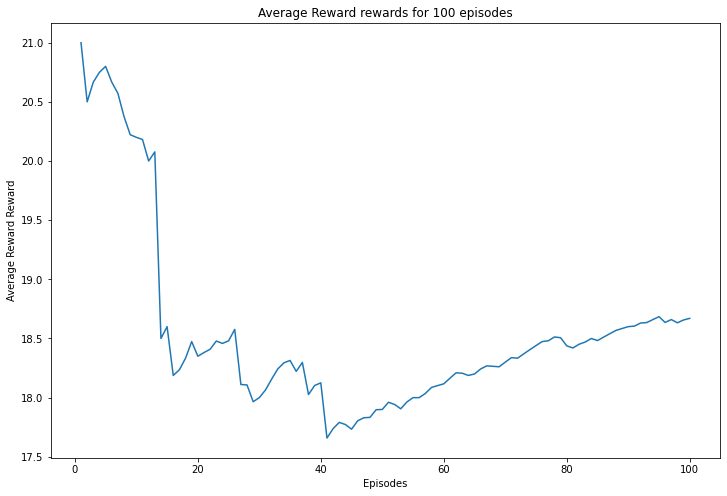

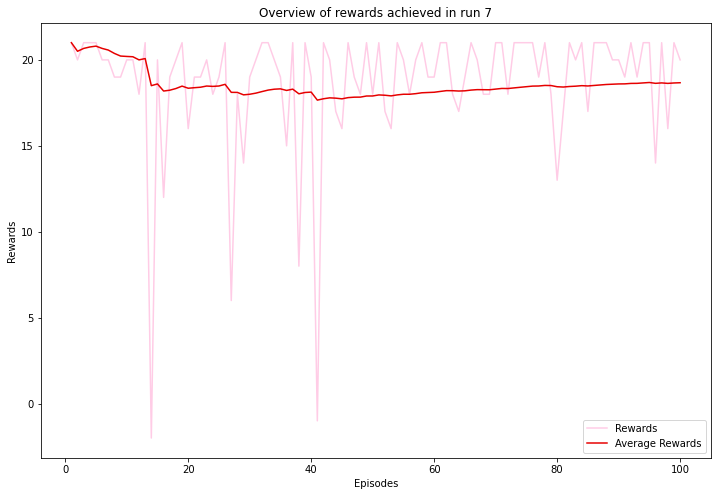

In [58]:
plot_rewards(re,100,"Individual Reward",7)
plot_rewards(ave_re,100,"Average Reward",7)
pretty_plot(re,ave_re,7)

### 8th game:
#### Average: 19.08
#### Num of games below 15 points: 5
#### Num of games below 0 points: 1

In [59]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 1, curr_reward: 17.0, running_avg_reward: 18.0, num of losses: 0
EP 2, curr_reward: 20.0, running_avg_reward: 18.667, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 19.25, num of losses: 0
EP 4, curr_reward: 17.0, running_avg_reward: 18.8, num of losses: 0
EP 5, curr_reward: 20.0, running_avg_reward: 19.0, num of losses: 0
EP 6, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 7, curr_reward: 18.0, running_avg_reward: 18.875, num of losses: 0
EP 8, curr_reward: 21.0, running_avg_reward: 19.111, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 19.3, num of losses: 0
EP 10, curr_reward: 20.0, running_avg_reward: 19.364, num of losses: 0
EP 11, curr_reward: 20.0, running_avg_reward: 19.417, num of losses: 0
EP 12, curr_reward: 21.0, running_avg_reward: 19.538, num of losses: 0
EP 13, curr_reward: 14.0, running_avg_reward: 19.143, num of losses: 1
EP 14, curr_reward: 21.0, run

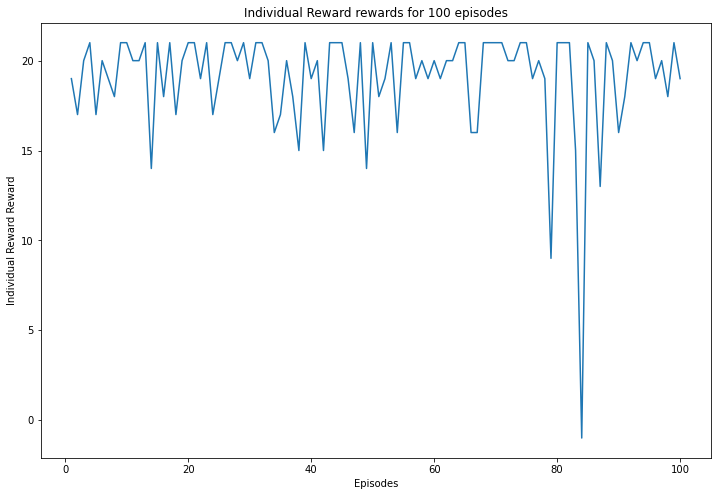

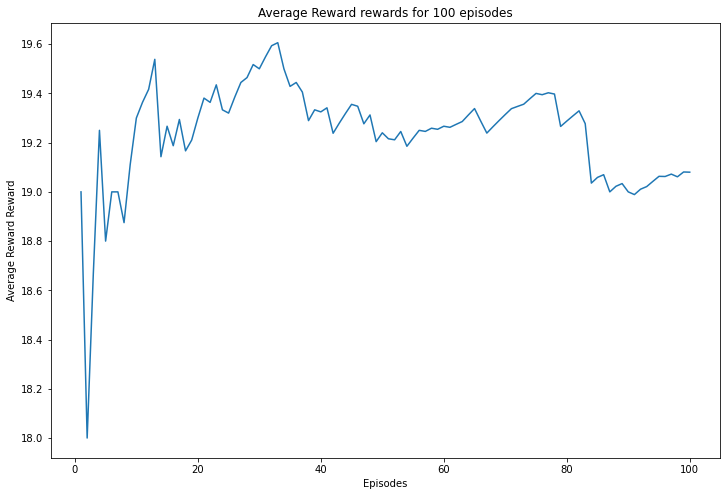

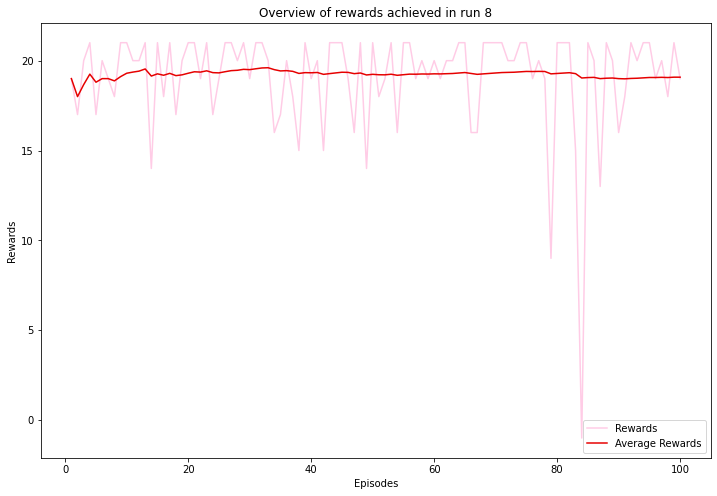

In [60]:
plot_rewards(re,100,"Individual Reward",8)
plot_rewards(ave_re,100,"Average Reward",8)
pretty_plot(re,ave_re,8)

### 9th game:
#### Average: 19.09
#### Num of games below 15 points: 8
#### Num of games below 0 points: 0

In [61]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 3, curr_reward: 14.0, running_avg_reward: 19.25, num of losses: 1
EP 4, curr_reward: 21.0, running_avg_reward: 19.6, num of losses: 1
EP 5, curr_reward: 20.0, running_avg_reward: 19.667, num of losses: 1
EP 6, curr_reward: 14.0, running_avg_reward: 18.857, num of losses: 2
EP 7, curr_reward: 18.0, running_avg_reward: 18.75, num of losses: 2
EP 8, curr_reward: 20.0, running_avg_reward: 18.889, num of losses: 2
EP 9, curr_reward: 15.0, running_avg_reward: 18.5, num of losses: 2
EP 10, curr_reward: 19.0, running_avg_reward: 18.545, num of losses: 2
EP 11, curr_reward: 20.0, running_avg_reward: 18.667, num of losses: 2
EP 12, curr_reward: 20.0, running_avg_reward: 18.769, num of losses: 2
EP 13, curr_reward: 21.0, running_avg_reward: 18.929, num of losses: 2
EP 14, curr_reward: 19.0, ru

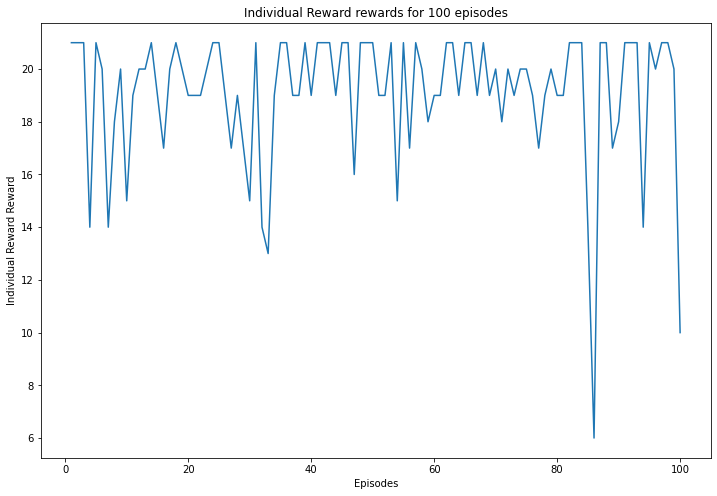

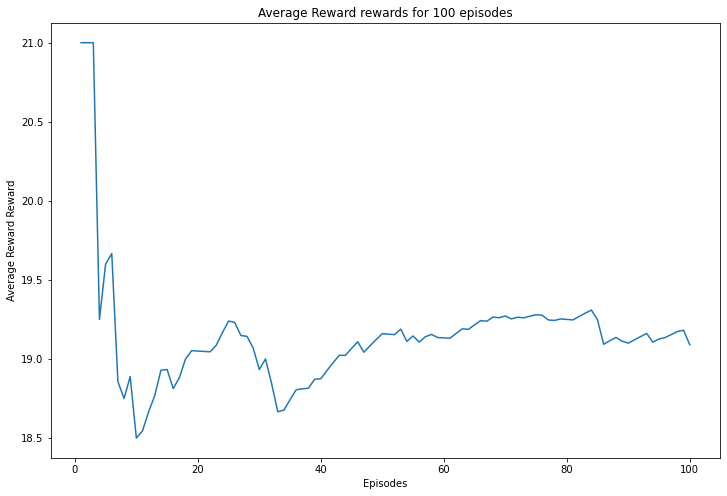

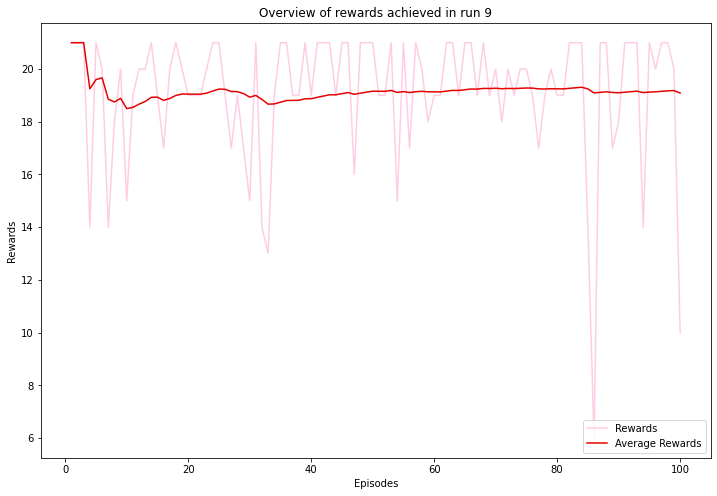

In [62]:
plot_rewards(re,100,"Individual Reward",9)
plot_rewards(ave_re,100,"Average Reward",9)
pretty_plot(re,ave_re,9)

### 10th game: 
#### Average: 19.47
#### Num of games below 15 points: 5
#### Num of games below 0 points: 0

In [63]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 1, curr_reward: 18.0, running_avg_reward: 18.5, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 19.333, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 19.75, num of losses: 0
EP 4, curr_reward: 17.0, running_avg_reward: 19.2, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 19.5, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 19.714, num of losses: 0
EP 7, curr_reward: 19.0, running_avg_reward: 19.625, num of losses: 0
EP 8, curr_reward: 19.0, running_avg_reward: 19.556, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 19.7, num of losses: 0
EP 10, curr_reward: 18.0, running_avg_reward: 19.545, num of losses: 0
EP 11, curr_reward: 19.0, running_avg_reward: 19.5, num of losses: 0
EP 12, curr_reward: 17.0, running_avg_reward: 19.308, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 19.429, num of losses: 0
EP 14, curr_reward: 18.0, run

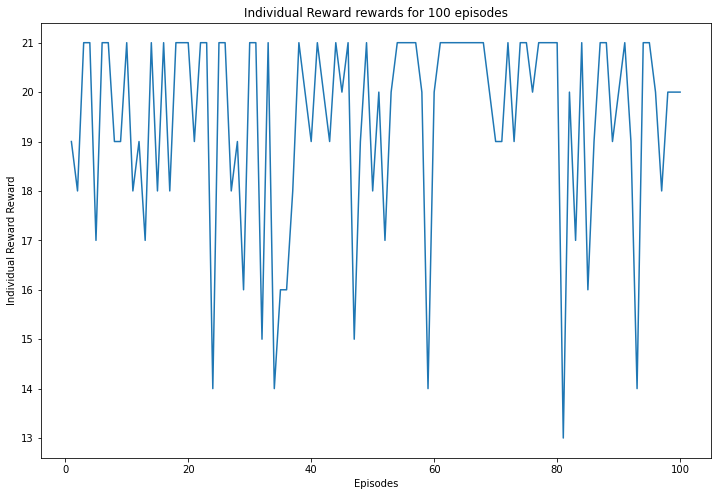

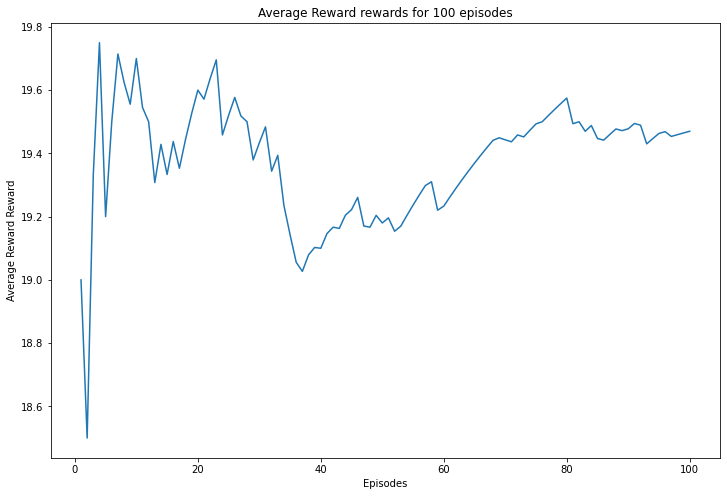

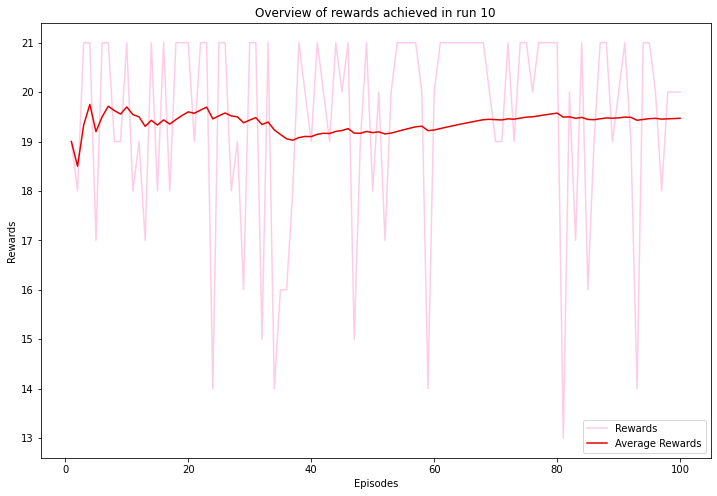

In [64]:
plot_rewards(re,100,"Individual Reward",10)
plot_rewards(ave_re,100,"Average Reward",10)
pretty_plot(re,ave_re,10)

# Play 1000 games with run4 agent

### 1st Game:
#### Average: 20.05
#### Num of games below 15 points: 1
#### Num of games below 0 points: 0

In [19]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


EP 0, curr_reward: 18.0, running_avg_reward: 18.0, num of losses: 0
EP 1, curr_reward: 19.0, running_avg_reward: 18.5, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 19.333, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 19.75, num of losses: 0
EP 4, curr_reward: 17.0, running_avg_reward: 19.2, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 19.5, num of losses: 0
EP 6, curr_reward: 17.0, running_avg_reward: 19.143, num of losses: 0
EP 7, curr_reward: 21.0, running_avg_reward: 19.375, num of losses: 0
EP 8, curr_reward: 18.0, running_avg_reward: 19.222, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 19.4, num of losses: 0
EP 10, curr_reward: 20.0, running_avg_reward: 19.455, num of losses: 0
EP 11, curr_reward: 21.0, running_avg_reward: 19.583, num of losses: 0
EP 12, curr_reward: 21.0, running_avg_reward: 19.692, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 19.786, num of losses: 0
EP 14, curr_reward: 18.0, r

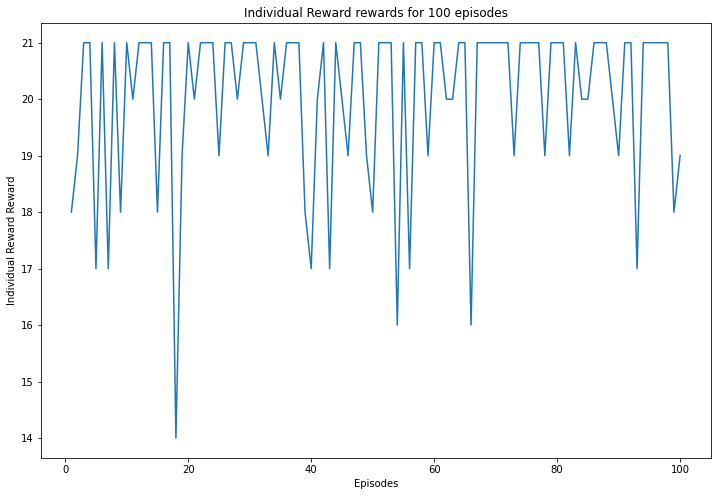

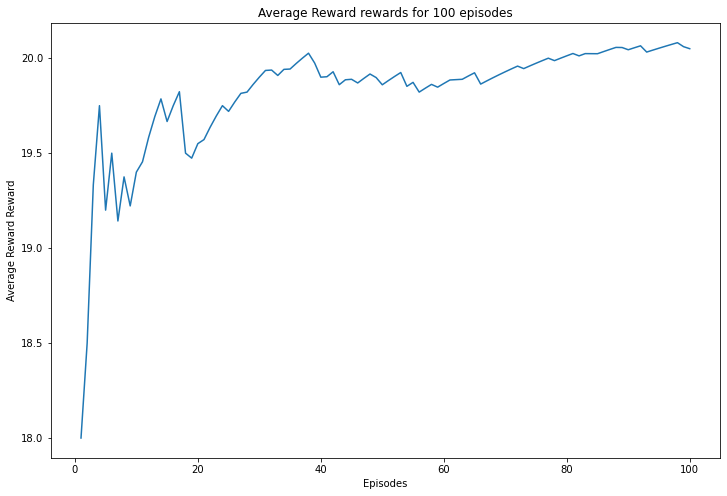

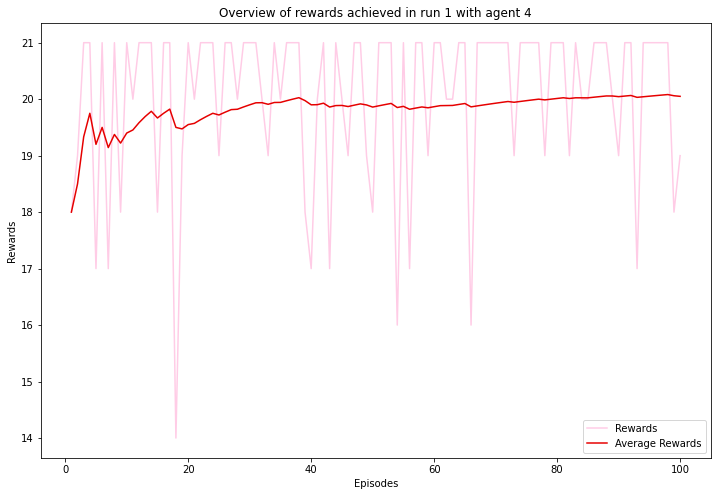

In [20]:
plot_rewards(re,100,"Individual Reward",1,4)
plot_rewards(ave_re,100,"Average Reward",1,4)
pretty_plot(re,ave_re,1,4)

### 2nd Game:
#### Average: 20.33
#### Num of games below 15 points: 0
#### Num of games below 0 points: 0

In [23]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)
#env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 2, curr_reward: 17.0, running_avg_reward: 19.667, num of losses: 0
EP 3, curr_reward: 18.0, running_avg_reward: 19.25, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 19.6, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 19.833, num of losses: 0
EP 6, curr_reward: 20.0, running_avg_reward: 19.857, num of losses: 0
EP 7, curr_reward: 19.0, running_avg_reward: 19.75, num of losses: 0
EP 8, curr_reward: 18.0, running_avg_reward: 19.556, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 19.7, num of losses: 0
EP 10, curr_reward: 16.0, running_avg_reward: 19.364, num of losses: 0
EP 11, curr_reward: 21.0, running_avg_reward: 19.5, num of losses: 0
EP 12, curr_reward: 21.0, running_avg_reward: 19.615, num of losses: 0
EP 13, curr_reward: 20.0, running_avg_reward: 19.643, num of losses: 0
EP 14, curr_reward: 18.0, ru

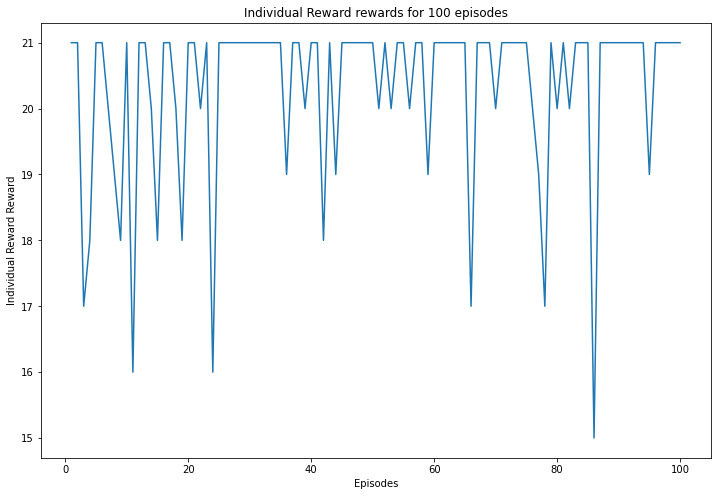

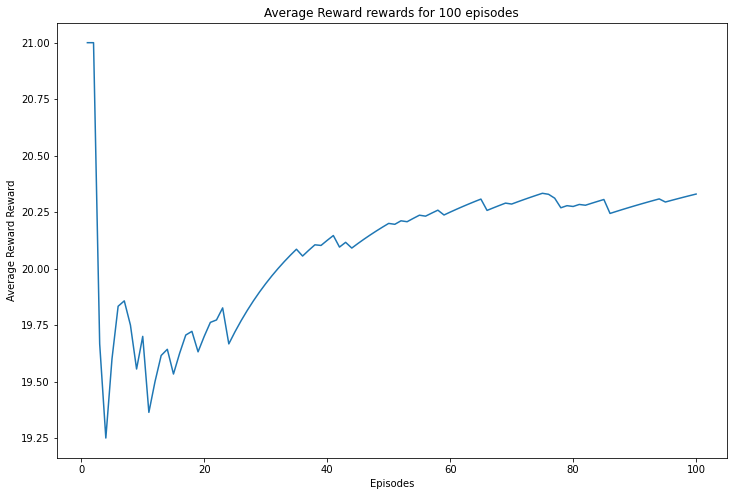

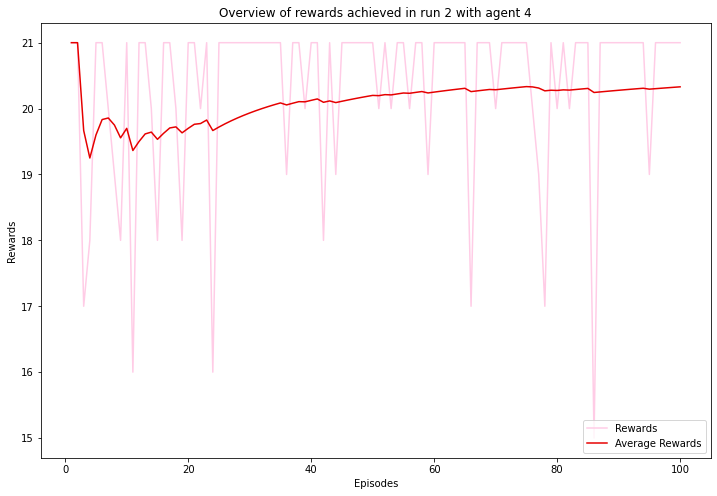

In [24]:
plot_rewards(re,100,"Individual Reward",2,4)
plot_rewards(ave_re,100,"Average Reward",2,4)
pretty_plot(re,ave_re,2,4)

### 3nd Game:
#### Average:                                                      20.26
#### Num of games below 15 points:                      2
#### Num of games below 0 points:                        0

In [25]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 2, curr_reward: 20.0, running_avg_reward: 20.667, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 20.75, num of losses: 0
EP 4, curr_reward: 15.0, running_avg_reward: 19.6, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 19.833, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 20.0, num of losses: 0
EP 7, curr_reward: 21.0, running_avg_reward: 20.125, num of losses: 0
EP 8, curr_reward: 21.0, running_avg_reward: 20.222, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 20.3, num of losses: 0
EP 10, curr_reward: 21.0, running_avg_reward: 20.364, num of losses: 0
EP 11, curr_reward: 21.0, running_avg_reward: 20.417, num of losses: 0
EP 12, curr_reward: 20.0, running_avg_reward: 20.385, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 20.429, num of losses: 0
EP 14, curr_reward: 21.0, r

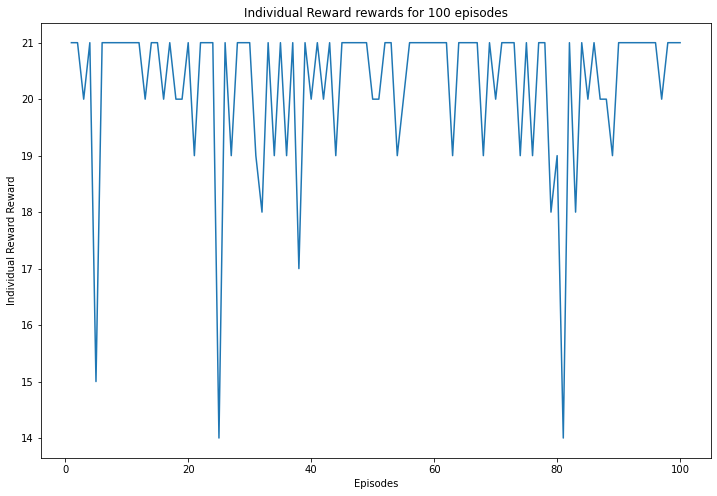

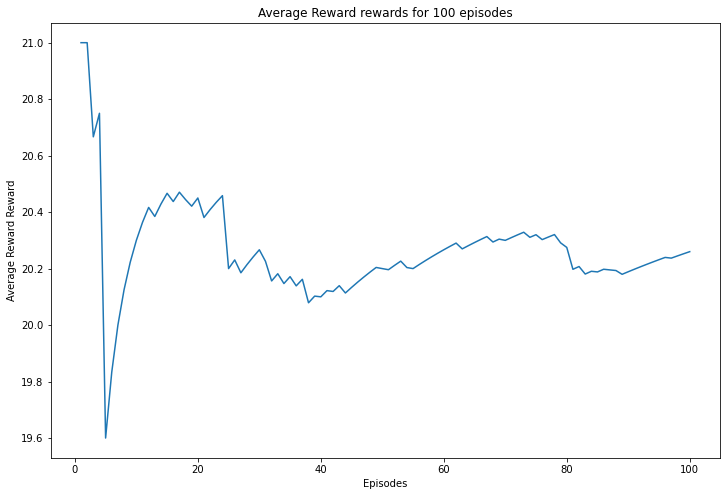

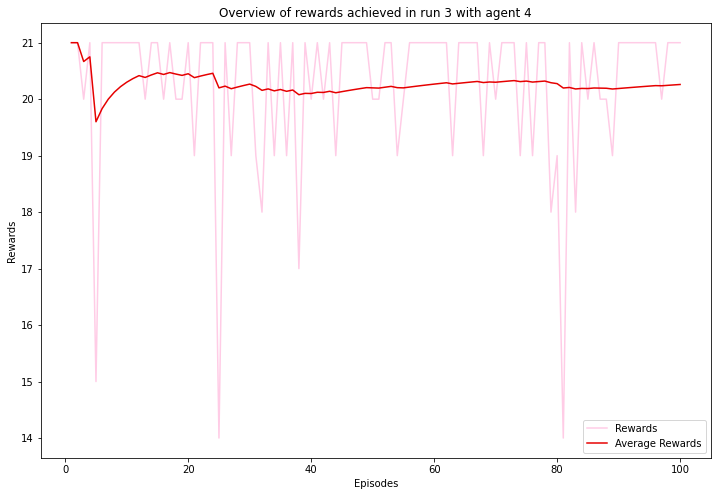

In [26]:
plot_rewards(re,100,"Individual Reward",3,4)
plot_rewards(ave_re,100,"Average Reward",3,4)
pretty_plot(re,ave_re,3,4)

### 4th Game:
#### Average: 20.18
#### Num of games below 15 points: 0 
#### Num of games below 0 points: 0 

In [27]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 19.0, running_avg_reward: 19.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 20.0, num of losses: 0
EP 2, curr_reward: 20.0, running_avg_reward: 20.0, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 20.25, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 20.4, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 20.5, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 20.571, num of losses: 0
EP 7, curr_reward: 19.0, running_avg_reward: 20.375, num of losses: 0
EP 8, curr_reward: 21.0, running_avg_reward: 20.444, num of losses: 0
EP 9, curr_reward: 20.0, running_avg_reward: 20.4, num of losses: 0
EP 10, curr_reward: 21.0, running_avg_reward: 20.455, num of losses: 0
EP 11, curr_reward: 20.0, running_avg_reward: 20.417, num of losses: 0
EP 12, curr_reward: 20.0, running_avg_reward: 20.385, num of losses: 0
EP 13, curr_reward: 20.0, running_avg_reward: 20.357, num of losses: 0
EP 14, curr_reward: 21.0, run

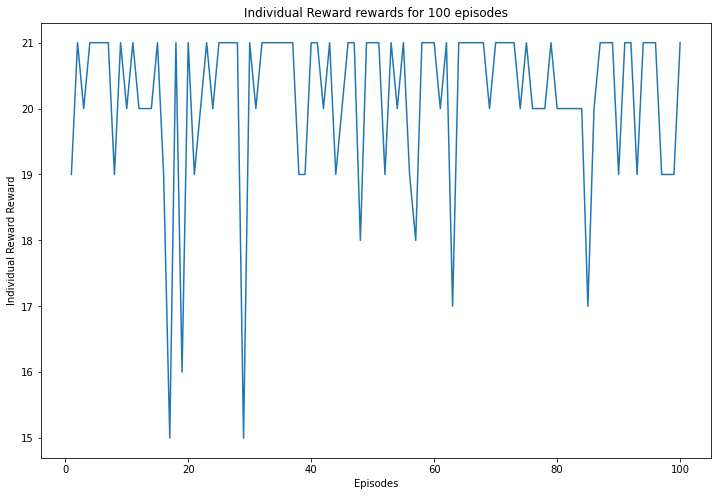

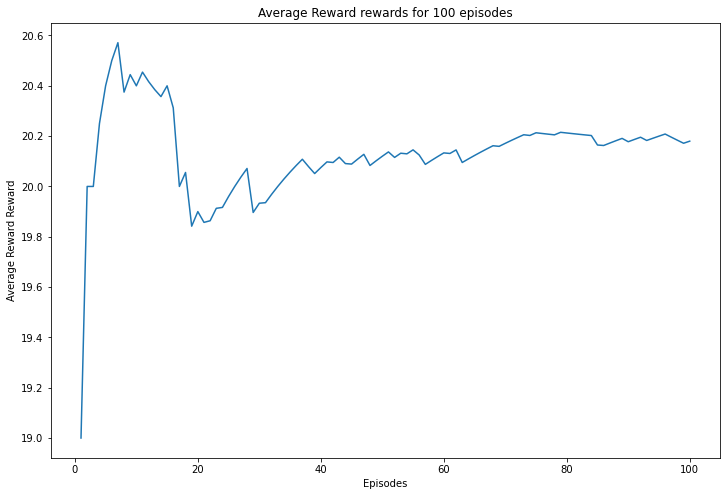

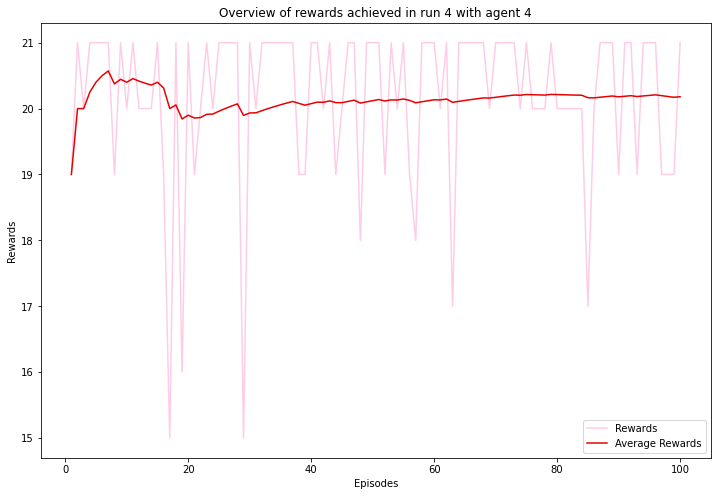

In [28]:
plot_rewards(re,100,"Individual Reward",4,4)
plot_rewards(ave_re,100,"Average Reward",4,4)
pretty_plot(re,ave_re,4,4)

### 5th Game:
#### Average:  20.23
#### Num of games below 15 points: 1 
#### Num of games below 0 points: 0 

In [29]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 3, curr_reward: 20.0, running_avg_reward: 20.75, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 20.8, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 20.833, num of losses: 0
EP 6, curr_reward: 20.0, running_avg_reward: 20.714, num of losses: 0
EP 7, curr_reward: 17.0, running_avg_reward: 20.25, num of losses: 0
EP 8, curr_reward: 19.0, running_avg_reward: 20.111, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 20.2, num of losses: 0
EP 10, curr_reward: 19.0, running_avg_reward: 20.091, num of losses: 0
EP 11, curr_reward: 18.0, running_avg_reward: 19.917, num of losses: 0
EP 12, curr_reward: 18.0, running_avg_reward: 19.769, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 19.857, num of losses: 0
EP 14, curr_reward: 21.0, ru

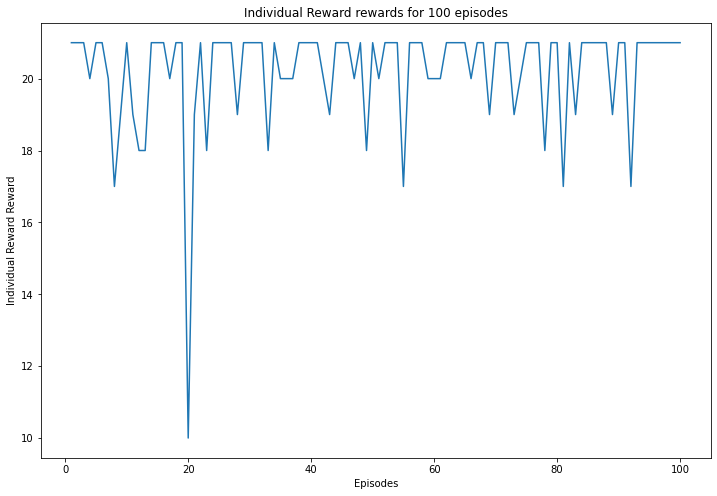

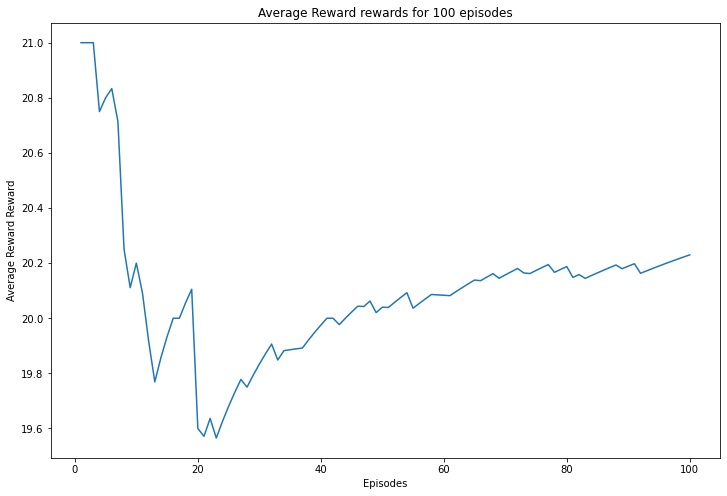

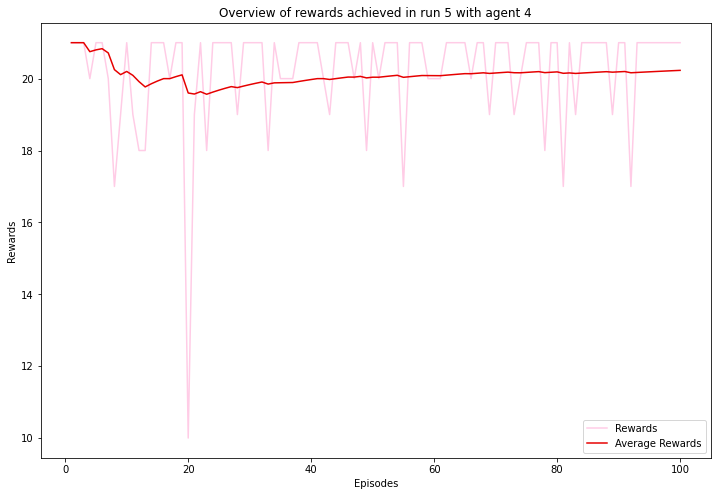

In [30]:
plot_rewards(re,100,"Individual Reward",5,4)
plot_rewards(ave_re,100,"Average Reward",5,4)
pretty_plot(re,ave_re,5,4)

### 6th Game:
#### Average:  20.31
#### Num of games below 15 points: 0 
#### Num of games below 0 points: 0 

In [31]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 20.0, running_avg_reward: 20.5, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 20.667, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 20.75, num of losses: 0
EP 4, curr_reward: 18.0, running_avg_reward: 20.2, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 20.333, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 20.429, num of losses: 0
EP 7, curr_reward: 20.0, running_avg_reward: 20.375, num of losses: 0
EP 8, curr_reward: 21.0, running_avg_reward: 20.444, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 20.5, num of losses: 0
EP 10, curr_reward: 21.0, running_avg_reward: 20.545, num of losses: 0
EP 11, curr_reward: 20.0, running_avg_reward: 20.5, num of losses: 0
EP 12, curr_reward: 19.0, running_avg_reward: 20.385, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 20.429, num of losses: 0
EP 14, curr_reward: 20.0, r

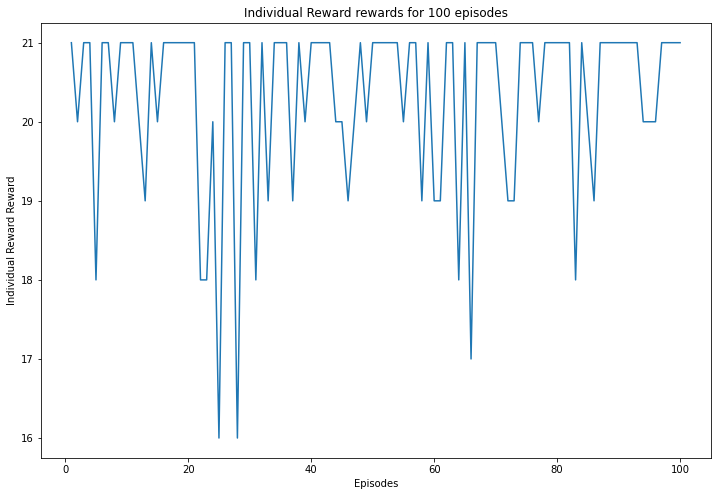

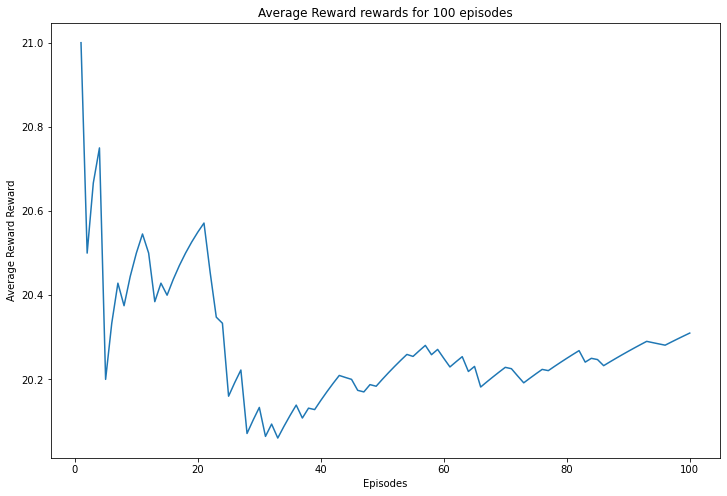

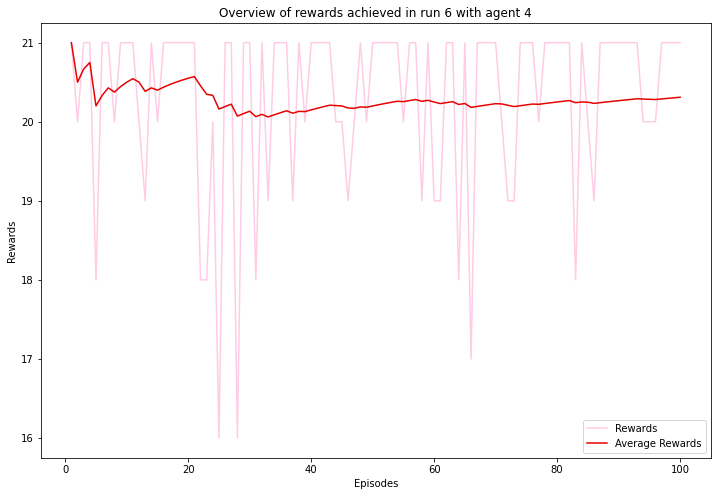

In [32]:
plot_rewards(re,100,"Individual Reward",6,4)
plot_rewards(ave_re,100,"Average Reward",6,4)
pretty_plot(re,ave_re,6,4)

### 7th Game:
#### Average: 20.14
#### Num of games below 15 points: 0 
#### Num of games below 0 points: 0 

In [33]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 7, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 8, curr_reward: 20.0, running_avg_reward: 20.889, num of losses: 0
EP 9, curr_reward: 17.0, running_avg_reward: 20.5, num of losses: 0
EP 10, curr_reward: 21.0, running_avg_reward: 20.545, num of losses: 0
EP 11, curr_reward: 20.0, running_avg_reward: 20.5, num of losses: 0
EP 12, curr_reward: 21.0, running_avg_reward: 20.538, num of losses: 0
EP 13, curr_reward: 19.0, running_avg_reward: 20.429, num of losses: 0
EP 14, curr_reward: 20.0, running_av

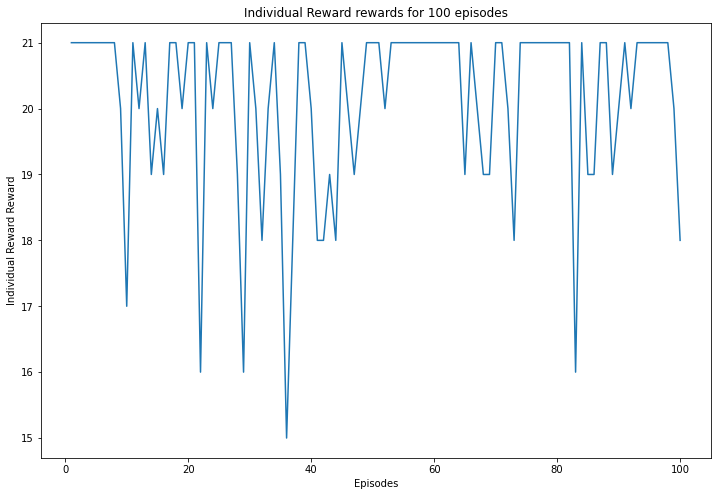

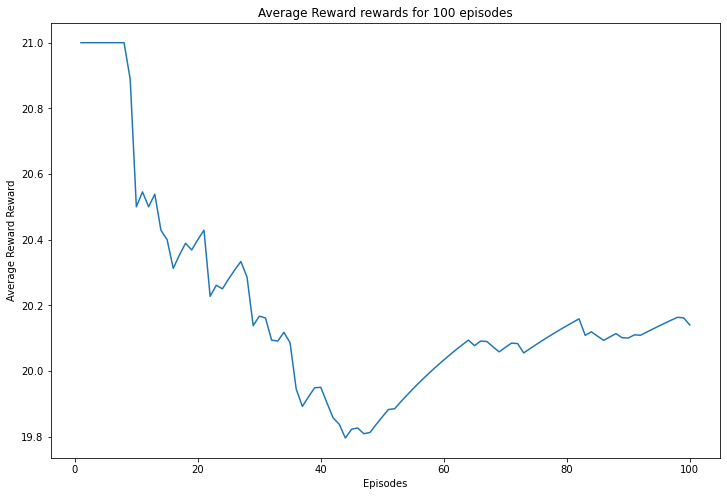

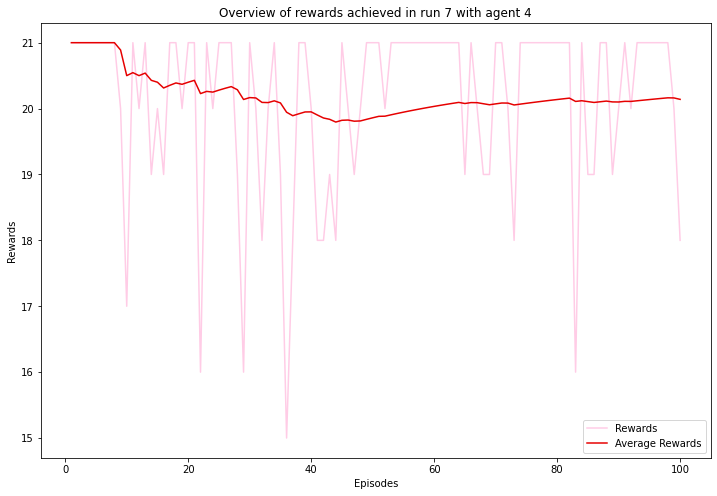

In [34]:
plot_rewards(re,100,"Individual Reward",7,4)
plot_rewards(ave_re,100,"Average Reward",7,4)
pretty_plot(re,ave_re,7,4)

### 8th Game:
#### Average: 19.92
#### Num of games below 15 points: 2
#### Num of games below 0 points:  0

In [35]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 7, curr_reward: 21.0, running_avg_reward: 21.0, num of losses: 0
EP 8, curr_reward: 20.0, running_avg_reward: 20.889, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 20.9, num of losses: 0
EP 10, curr_reward: 21.0, running_avg_reward: 20.909, num of losses: 0
EP 11, curr_reward: 21.0, running_avg_reward: 20.917, num of losses: 0
EP 12, curr_reward: 9.0, running_avg_reward: 20.0, num of losses: 1
EP 13, curr_reward: 21.0, running_avg_reward: 20.071, num of losses: 1
EP 14, curr_reward: 20.0, running_avg

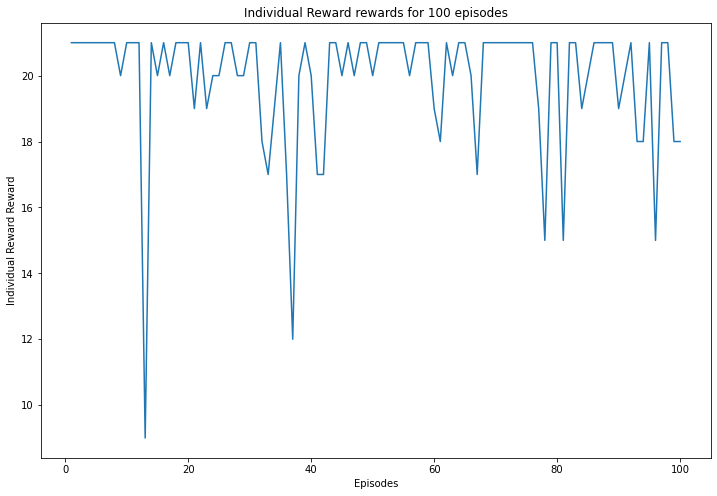

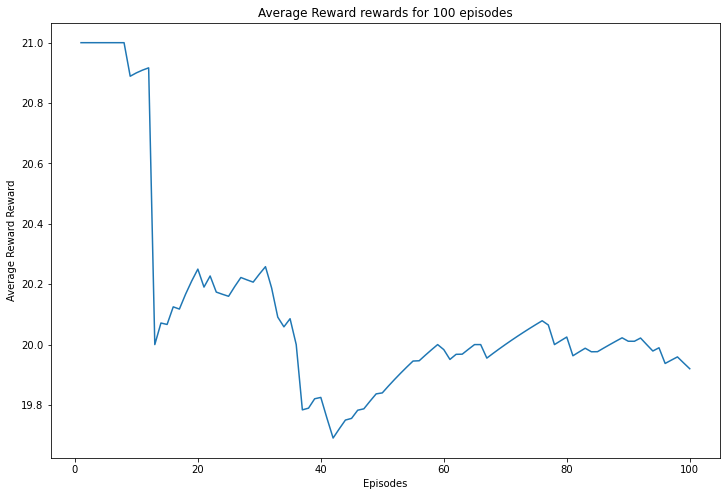

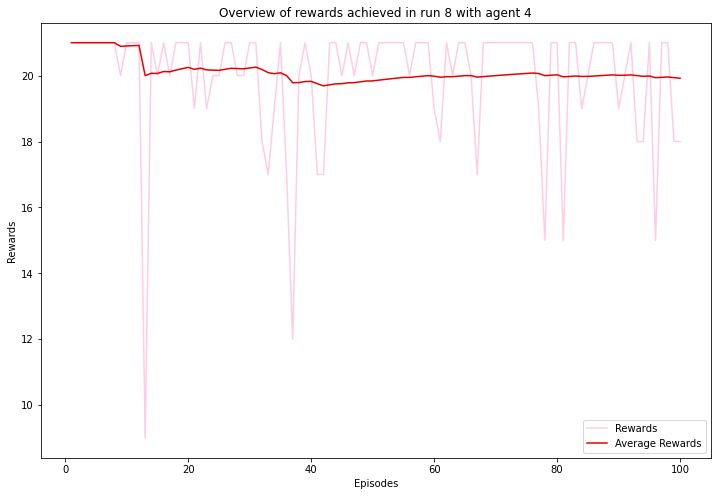

In [36]:
plot_rewards(re,100,"Individual Reward",8,4)
plot_rewards(ave_re,100,"Average Reward",8,4)
pretty_plot(re,ave_re,8,4)

### 9th Game:
#### Average: 20.14
#### Num of games below 15 points: 1
#### Num of games below 0 points:  0

In [37]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 20.0, running_avg_reward: 20.0, num of losses: 0
EP 1, curr_reward: 17.0, running_avg_reward: 18.5, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 19.333, num of losses: 0
EP 3, curr_reward: 17.0, running_avg_reward: 18.75, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 19.2, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 19.5, num of losses: 0
EP 6, curr_reward: 20.0, running_avg_reward: 19.571, num of losses: 0
EP 7, curr_reward: 15.0, running_avg_reward: 19.0, num of losses: 0
EP 8, curr_reward: 21.0, running_avg_reward: 19.222, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 19.4, num of losses: 0
EP 10, curr_reward: 21.0, running_avg_reward: 19.545, num of losses: 0
EP 11, curr_reward: 19.0, running_avg_reward: 19.5, num of losses: 0
EP 12, curr_reward: 21.0, running_avg_reward: 19.615, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 19.714, num of losses: 0
EP 14, curr_reward: 20.0, runni

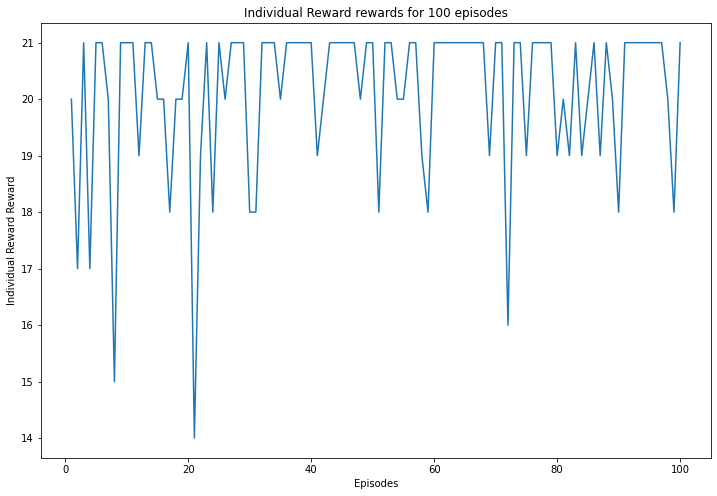

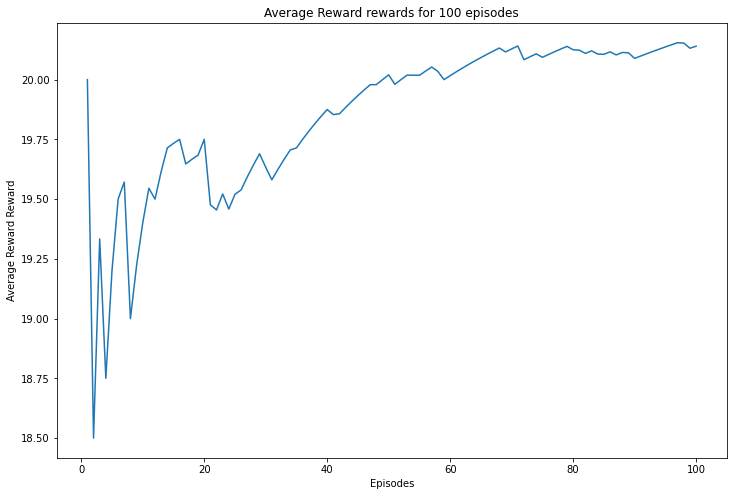

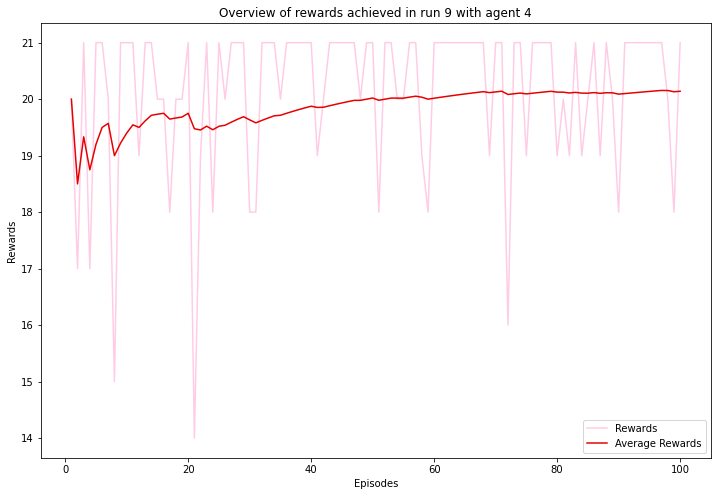

In [38]:
plot_rewards(re,100,"Individual Reward",9,4)
plot_rewards(ave_re,100,"Average Reward",9,4)
pretty_plot(re,ave_re,9,4)

### 10th Game:
#### Average: 20.5
#### Num of games below 15 points:  0
#### Num of games below 0 points: 0

In [39]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 20.0, running_avg_reward: 20.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 20.5, num of losses: 0
EP 2, curr_reward: 20.0, running_avg_reward: 20.333, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 20.5, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 20.6, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 20.667, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 20.714, num of losses: 0
EP 7, curr_reward: 21.0, running_avg_reward: 20.75, num of losses: 0
EP 8, curr_reward: 20.0, running_avg_reward: 20.667, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 20.7, num of losses: 0
EP 10, curr_reward: 20.0, running_avg_reward: 20.636, num of losses: 0
EP 11, curr_reward: 19.0, running_avg_reward: 20.5, num of losses: 0
EP 12, curr_reward: 20.0, running_avg_reward: 20.462, num of losses: 0
EP 13, curr_reward: 21.0, running_avg_reward: 20.5, num of losses: 0
EP 14, curr_reward: 21.0, runni

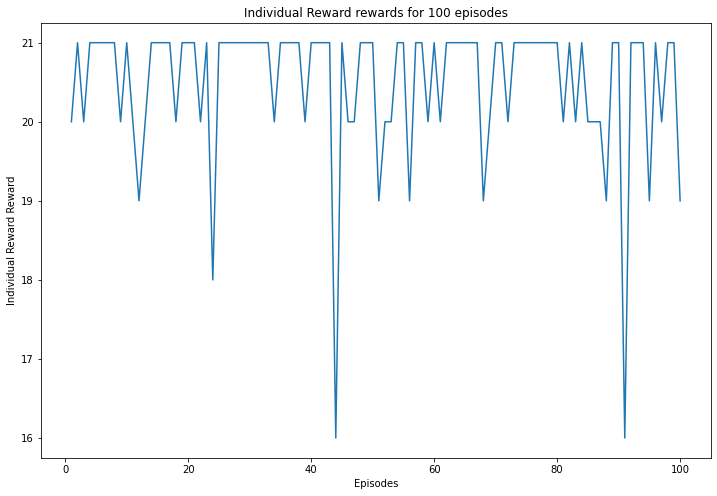

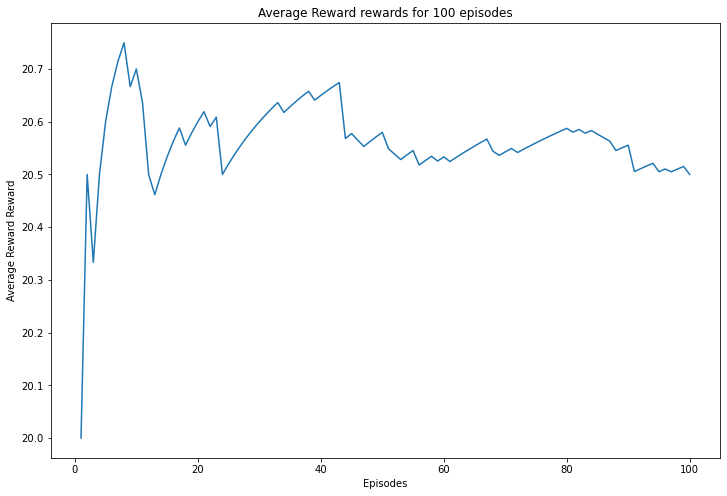

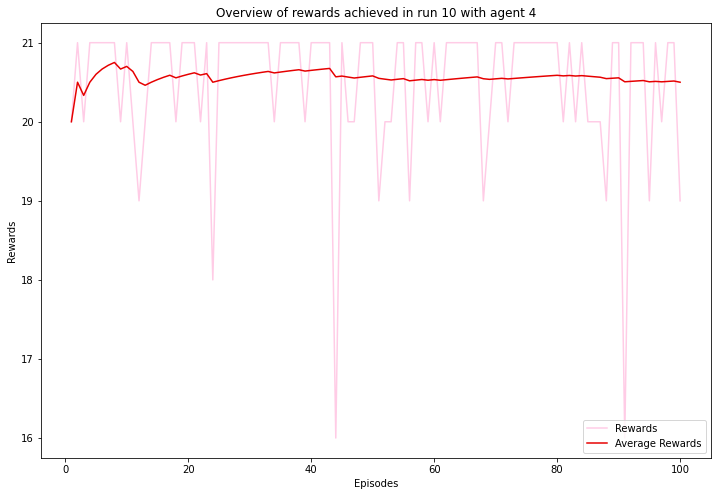

In [40]:
plot_rewards(re,100,"Individual Reward",10,4)
plot_rewards(ave_re,100,"Average Reward",10,4)
pretty_plot(re,ave_re,10,4)

In [58]:
N_EPDS = 100
ave_re, re = game_on(env,agent,device)

  0%|          | 0/100 [00:00<?, ?it/s]

EP 0, curr_reward: 20.0, running_avg_reward: 20.0, num of losses: 0
EP 1, curr_reward: 21.0, running_avg_reward: 20.5, num of losses: 0
EP 2, curr_reward: 21.0, running_avg_reward: 20.667, num of losses: 0
EP 3, curr_reward: 21.0, running_avg_reward: 20.75, num of losses: 0
EP 4, curr_reward: 21.0, running_avg_reward: 20.8, num of losses: 0
EP 5, curr_reward: 21.0, running_avg_reward: 20.833, num of losses: 0
EP 6, curr_reward: 21.0, running_avg_reward: 20.857, num of losses: 0
EP 7, curr_reward: 21.0, running_avg_reward: 20.875, num of losses: 0
EP 8, curr_reward: 20.0, running_avg_reward: 20.778, num of losses: 0
EP 9, curr_reward: 21.0, running_avg_reward: 20.8, num of losses: 0
EP 10, curr_reward: 21.0, running_avg_reward: 20.818, num of losses: 0
EP 11, curr_reward: 21.0, running_avg_reward: 20.833, num of losses: 0
EP 12, curr_reward: 19.0, running_avg_reward: 20.692, num of losses: 0
EP 13, curr_reward: 20.0, running_avg_reward: 20.643, num of losses: 0
EP 14, curr_reward: 21.0,

KeyboardInterrupt: 

In [59]:
env.close()